In [1]:
import glob
# from slab import *
#import PyInventor
#from PyInventor import *
%load_ext autoreload
%autoreload 2
#import pyEPR as epr
#from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

import pandas as pd
import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()    
Q = ureg.Quantity
import os
import matplotlib.pyplot as plt

def flt2strfmt(val, fmt='%.3f', units='mm'):
    return (fmt % val) + units

import matplotlib
import datetime

# Add junction and chip

In [2]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''

# Define the cavity parameters [mm]
z_cav_1 = 55
y_cav_1 = 25
x_cav_1 = 5
z_cav_2 = 55
y_cav_2 = 25
x_cav_2 = 5
z_offset = 0
cav_thickness = 1

# Define the coupler parameters [mmm]
z_coupler = 100.
y_coupler = 25.
x_coupler = 10.

# Offsets of the junction pads
ycoupler_offset = 0.
zcoupler_offset = 0.

# Light and heavy modes (500, 100 um)
# l_junc = 500e-3
# l_junc = 100e-3
l_junc = 0.05
coupler_pads = (x_coupler - l_junc) / 2
y_pads = 0.1
w_junc = l_junc / 2 * 1e-3

In [3]:
# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
ref_name = 'monolithic_pads_l_coupled_bbq_y11'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

# Geometry parameters
zcav1 = EM_design.set_variable('z_cav_1', flt2strfmt(z_cav_1))
ycav1 = EM_design.set_variable('y_cav_1', flt2strfmt(y_cav_1))
xcav1 = EM_design.set_variable('x_cav_1', flt2strfmt(x_cav_1))
zcav2 = EM_design.set_variable('z_cav_2', flt2strfmt(z_cav_2))
ycav2 = EM_design.set_variable('y_cav_2', flt2strfmt(y_cav_2))
xcav2 = EM_design.set_variable('x_cav_2', flt2strfmt(x_cav_2))
zcpl  = EM_design.set_variable('z_coupler', flt2strfmt(z_coupler))
ycpl  = EM_design.set_variable('y_coupler', flt2strfmt(y_coupler))
xcpl  = EM_design.set_variable('x_coupler', flt2strfmt(x_coupler))
ycpl_offset = EM_design.set_variable('ycoupler_offset',
                                    flt2strfmt(ycoupler_offset))
zcpl_offset = EM_design.set_variable('zcoupler_offset',
                                    flt2strfmt(zcoupler_offset))
z_offset  = EM_design.set_variable('z_offset', flt2strfmt(z_offset))
x_cpl_offset = EM_design.set_variable('x_cpl_offset', flt2strfmt(2e3*x_cav_1))
tcav = EM_design.set_variable('cav_thickness', flt2strfmt(cav_thickness))
cpl_pads = EM_design.set_variable('coupler_pads', flt2strfmt(coupler_pads))
ypads = EM_design.set_variable('y_pads', flt2strfmt(y_pads))
ljunc = EM_design.set_variable('l_junc', flt2strfmt(l_junc))

print(f'z_offset: {z_offset}')
print(f'x_cpl_offset: {x_cpl_offset}')

# Origin
pos=[0, 0, 0]

# Draw the cavities
## Define the cavity and coupler dimensions and positions
cav1_dims = [xcav1, ycav1, zcav1]
cav2_dims = [xcav1+tcav, ycav1+tcav, zcav1+tcav]
cav1_pos = [0, ycav1/2, zcav1/2]
cpl_dims = [xcpl, ycpl, zcpl/2]
cplout_dims = [xcpl+tcav, ycpl+tcav, zcpl/2+tcav]
cpl_pos = [0, 0, 0]
cav2_dims = [xcav2, ycav2, zcav2]
cav2_pos = [0, ycav1+ycpl+ycav2/2, zcav1/2]

# cav1 = model.draw_box_center(cav1_pos, cav1_dims, name='cavity_1')
pad1_pos = [-cpl_pads/2-ljunc/2, ycpl_offset, zcpl_offset]
pad2_pos = [cpl_pads/2+ljunc/2, ycpl_offset, zcpl_offset]

pad_dims = [cpl_pads,  ypads, xcpl/10]
cpl  = model.draw_box_center(cpl_pos, cpl_dims, name='coupler')
pad1 = model.draw_box_center(pad1_pos, pad_dims, name='pad1')
pad2 = model.draw_box_center(pad2_pos, pad_dims, name='pad2')

# PEC cavity subtraction and realization
# cplout  = model.draw_box_center(cpl_pos, cplout_dims, name='coupler_outer')
# model.subtract(cplout, [cpl], keep_originals=True)
# model.assign_material(cplout, material='pec')

# cav2 = model.draw_box_center(cav2_pos, cav2_dims, name='cavity_2')

# Seed mesh for coupler box before uniting with cavities
# model.mesh_length(name_mesh='cpl', objects=[cpl], 
#                  max_length='%.3fum'%200)

#cavity = model.unite(names=['cavity_1', 'cavity_2','coupler'], 
#                     keep_originals=False)

# model.subtract(cpl, [pad1, pad2], keep_originals=False)



junc_loc = [0, ycpl_offset, zcpl_offset]
jj=model.draw_rect_center(pos=junc_loc, x_size=xcpl-2*cpl_pads,
                          y_size=0,
                          z_size = w_junc,
                          name='jj')

project_name: monolithic_pads_l_coupled_bbq_y11_220611
path: Z:\tcav\ipynbs\HFSS\monolithic_pads_l_coupled_bbq_y11_220611.aedt


C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: monolithic_pads_l_coupled_bbq_y11_220611.aedt
C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


z_offset: z_offset
x_cpl_offset: x_cpl_offset


In [4]:
# model.assign_perfect_E([pad_1, pad_2], name='TPads')
Lj_val=10.  #<---this sets the nominal Lj_val, should be same as start
L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
jj_line=model.draw_polyline(jj.make_center_line(axis='X'), 
                            closed=False, name='jj_line')

### Change solution type to Driven Modal before assigning the lumped port

In [5]:
jj.make_lumped_port('X', z0=1e6)

## Postprocessing, blackbox quantization

In [ ]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, fcpy, ycpy, yp, pl, pc, gD, chippp
    
    else:
        return wp, Lp, Cp, fcpy, ycpy, yp, None, None, None, None

In [109]:
## Load the data manually exported from HFSS Y-parameter plots

# Load the data from file, combine as one wide frequency sweep
yredata = []
yimdata = []
fdata = []
# Set the directories and name the files in a sane fashion
# dstr = '220205'
# dstr = '211217'
# dstr ='220511'
dstr ='220513'
data_prefix = f'../data/y11_monolithic_pads'
data_prefix = '../data/y11_ycpl_sweep'
# data_prefix = '../data/y11_zcpl_sweep'
is_zcpl_offset = False
# is_zcpl_offset = True
is_ycpl_offset = True
# is_ycpl_offset = False
fswp1 = f'{data_prefix}_5_25GHz_50um_offset_{dstr}.csv'
fswp1 = f'{data_prefix}_2_20GHz_{dstr}.csv'
# fswp1 = f'{data_prefix}_5_25GHz_50um_{dstr}.csv'

# Iterate over all of the files

# JJ position sweep unraveling
data = np.genfromtxt(fswp1, delimiter=',', skip_header=1).T

if is_zcpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = z_coupler / 4
elif is_ycpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = y_coupler / 2
else:
    filenames = [fswp1]
    for f in filenames:
        data = np.genfromtxt(f, delimiter=',', skip_header=1).T
        fdata.append(data[0])
        yredata.append(data[1])
        yimdata.append(data[2])   

# Combine and flatten the data
# fdata = np.asarray(fdata).flatten()
# yredata = np.asarray(yredata).flatten()
#yimdata = np.asarray(yimdata).flatten()
ydata = yredata + 1j * yimdata

# Remove last point
xdata = xdata[0:-1]
ydata = ydata[0:-1]

ydata.shape

(23, 20001)

In [110]:
xdata.size

23

In [111]:
xdata

array([ 0.  ,  0.75,  1.25,  1.5 ,  2.25,  2.5 ,  3.  ,  3.75,  4.5 ,
        5.  ,  5.25,  6.  ,  6.25,  6.75,  7.5 ,  8.25,  8.75,  9.  ,
        9.75, 10.  , 10.5 , 11.25, 12.  ])

In [112]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

In [113]:
def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

In [114]:
def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

<IPython.core.display.Javascript object>


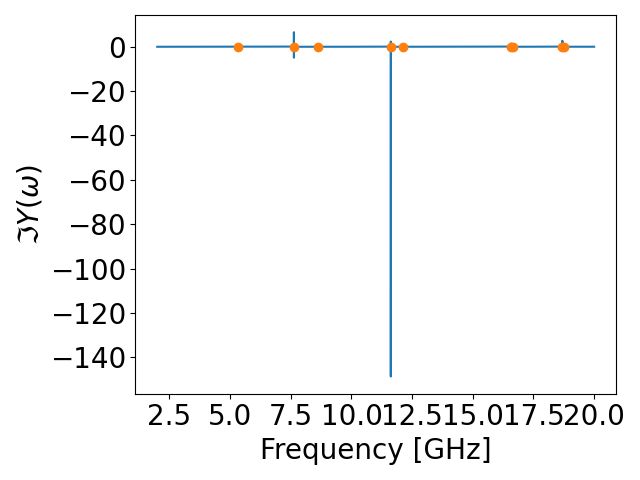

<IPython.core.display.Javascript object>


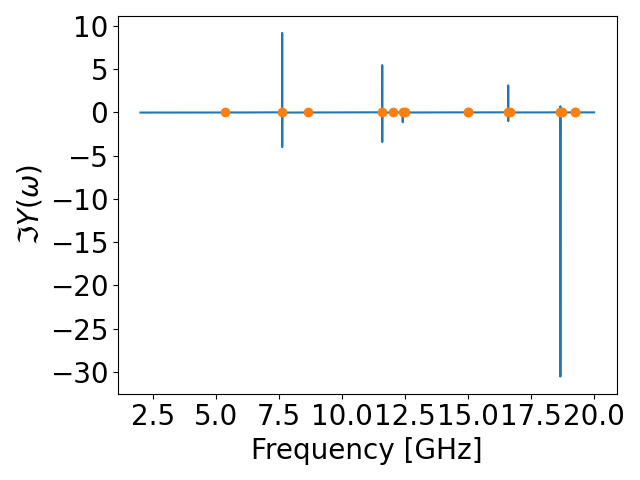

<IPython.core.display.Javascript object>


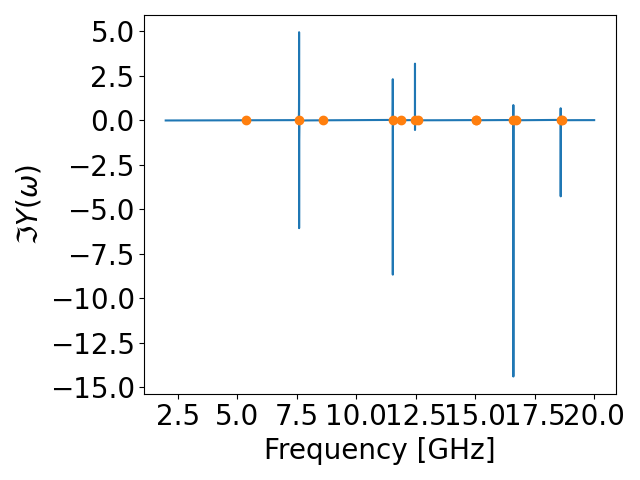

<IPython.core.display.Javascript object>


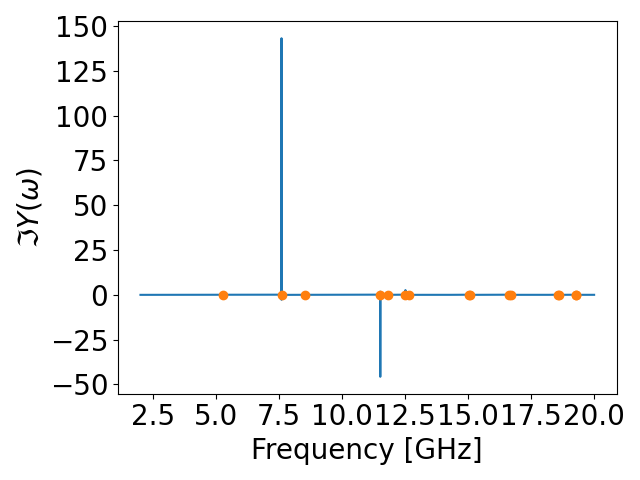

<IPython.core.display.Javascript object>


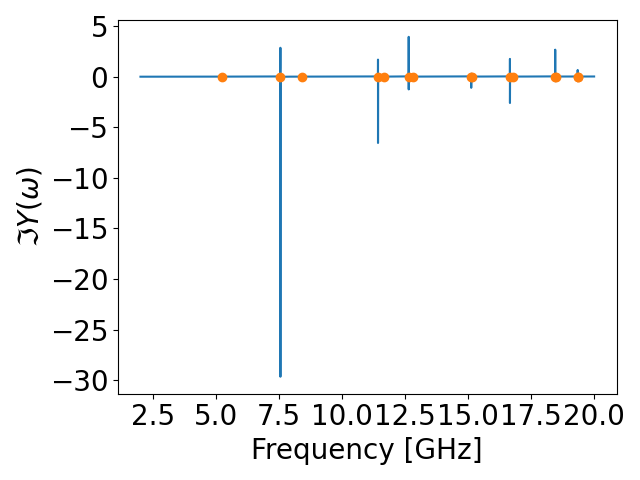

<IPython.core.display.Javascript object>


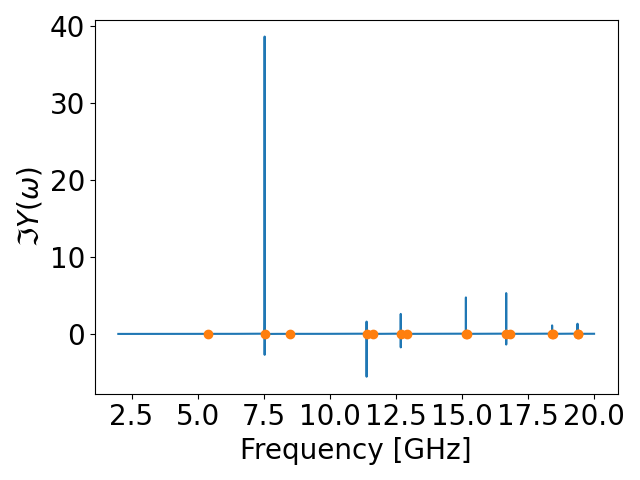

<IPython.core.display.Javascript object>


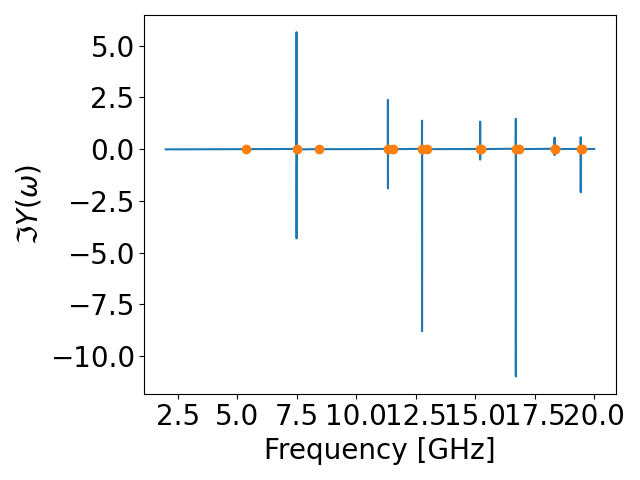

<IPython.core.display.Javascript object>


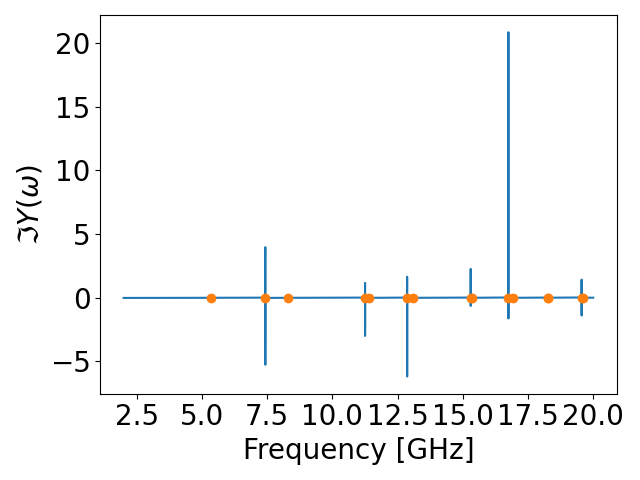

<IPython.core.display.Javascript object>


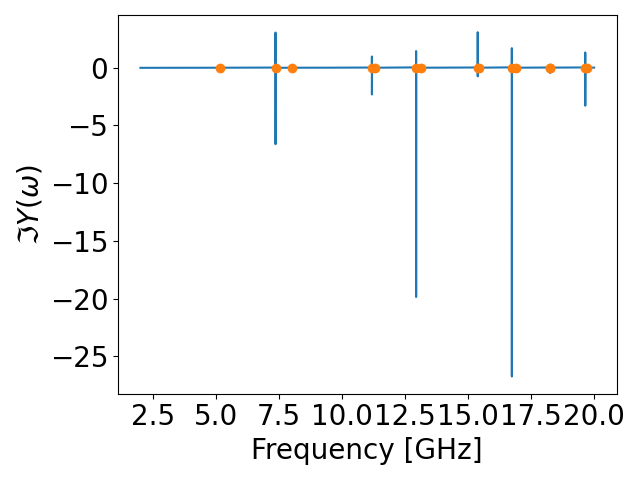

<IPython.core.display.Javascript object>


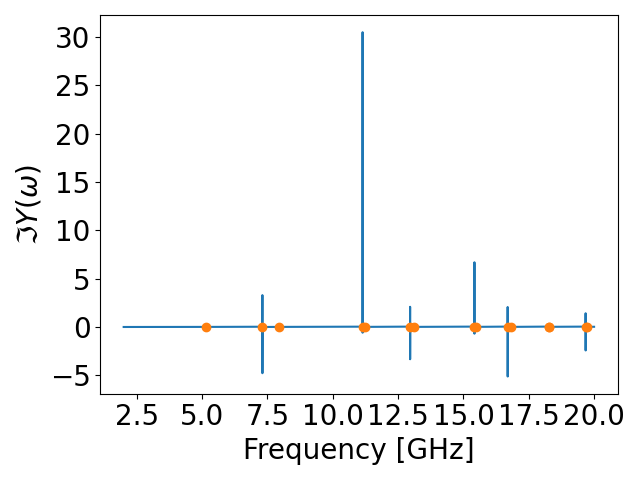

<IPython.core.display.Javascript object>


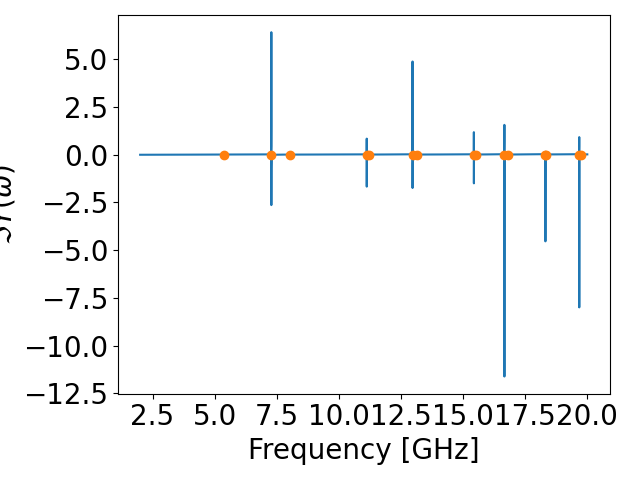

<IPython.core.display.Javascript object>


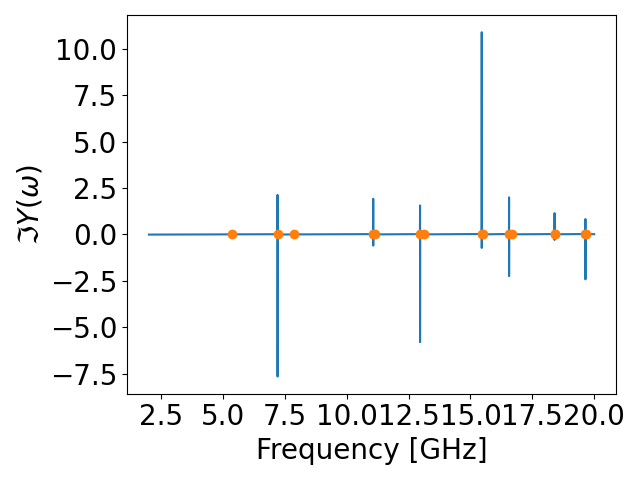

<IPython.core.display.Javascript object>


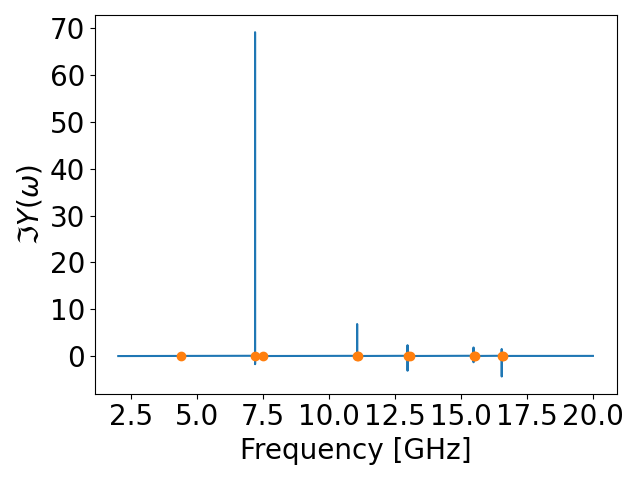

<IPython.core.display.Javascript object>


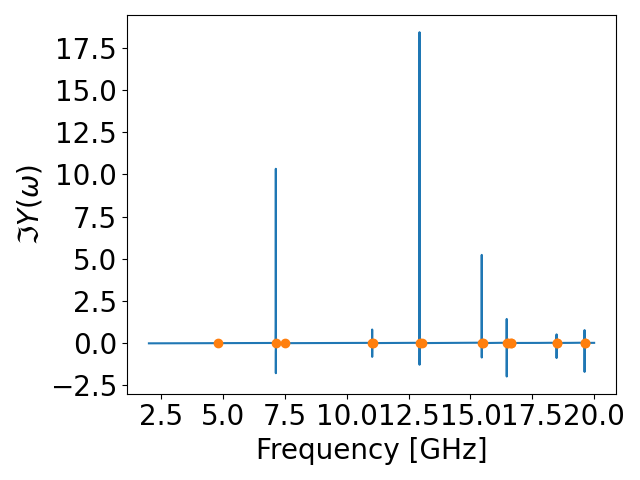

<IPython.core.display.Javascript object>


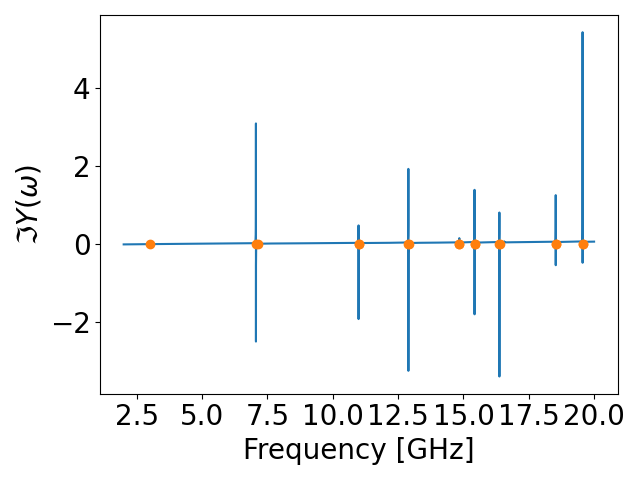

<IPython.core.display.Javascript object>


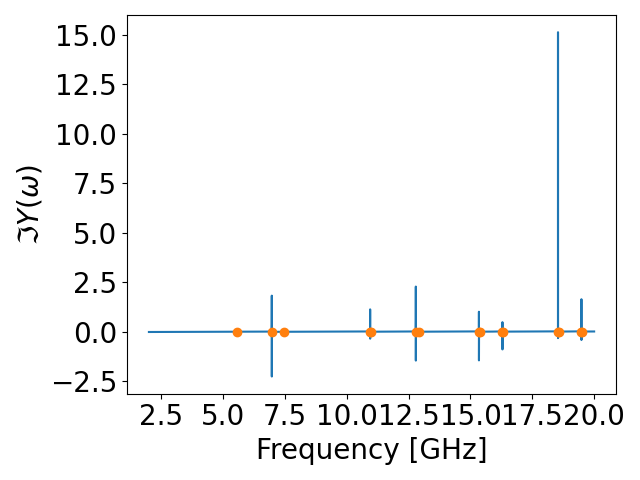

<IPython.core.display.Javascript object>


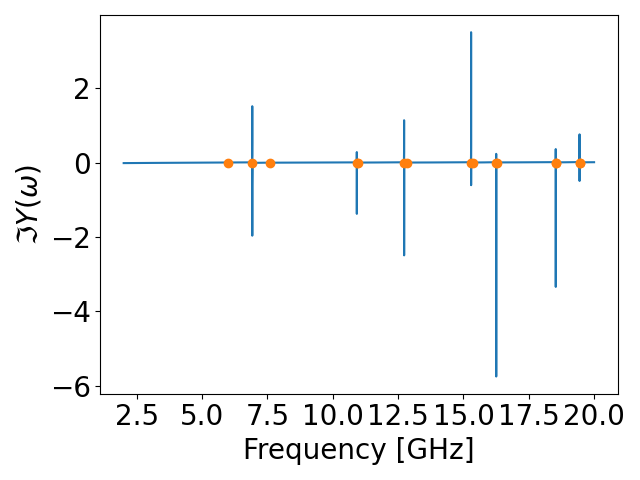

<IPython.core.display.Javascript object>


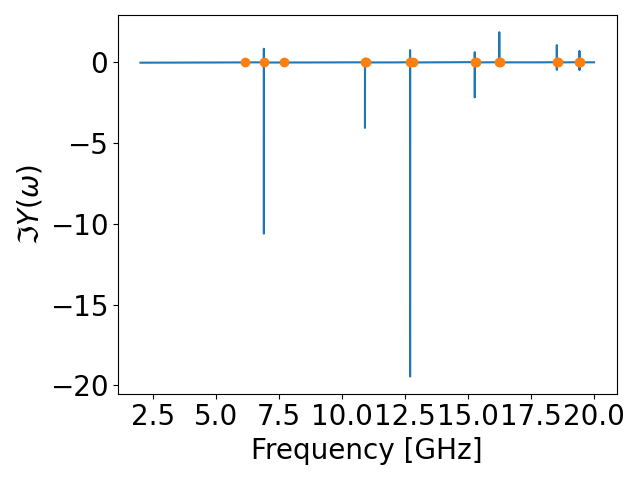

<IPython.core.display.Javascript object>


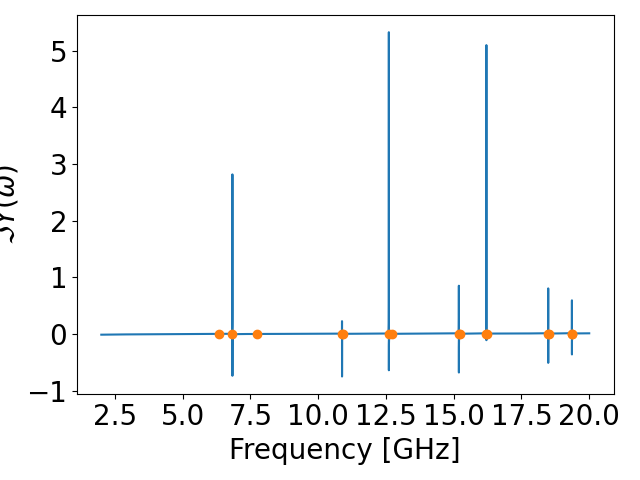

C:\Users\NMATER~1\AppData\Local\Temp/ipykernel_11912/3163046216.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, tight_layout=True)


<IPython.core.display.Javascript object>


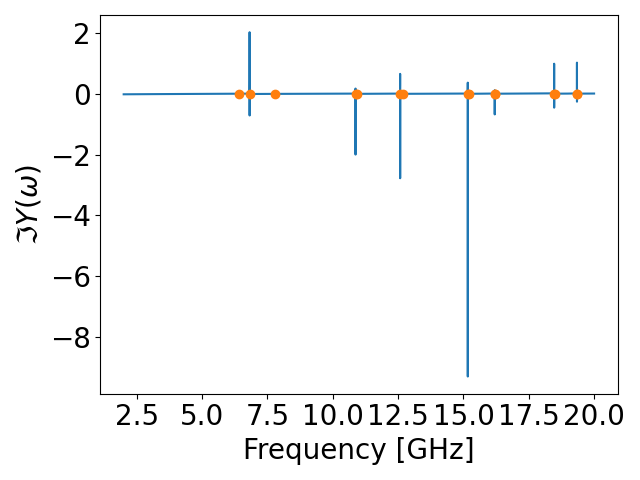

<IPython.core.display.Javascript object>


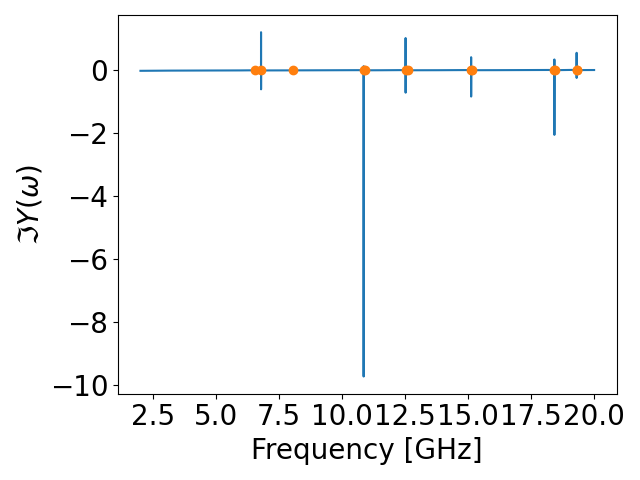

<IPython.core.display.Javascript object>


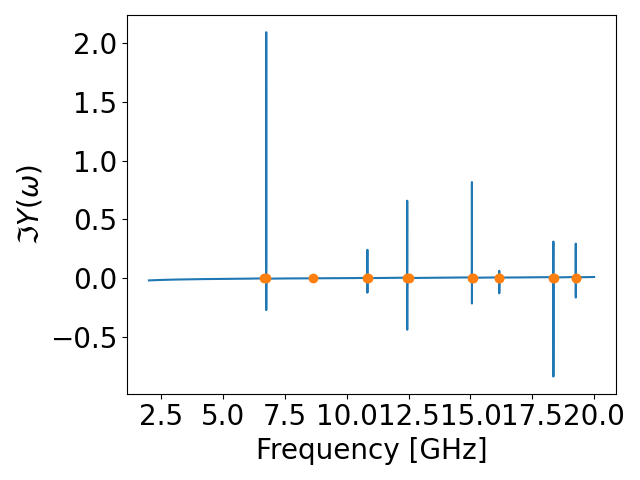

<IPython.core.display.Javascript object>


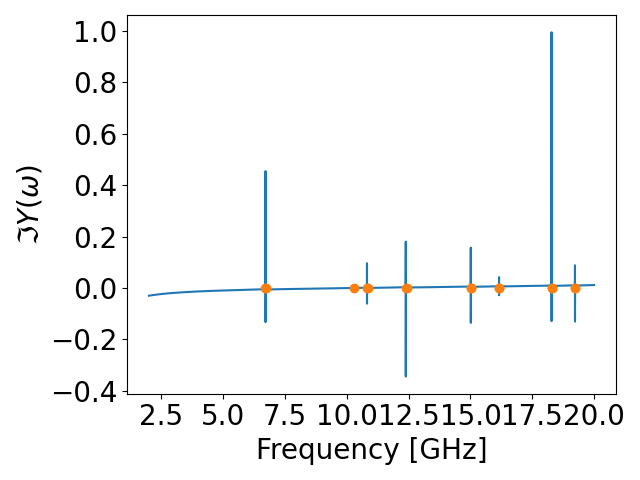

In [115]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
for y in ydata:
    wp, Lp, Cp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
    get_wp_Cp_Lp(fdata, y, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.plot(fdata, y.imag)
    ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
    ax.set_ylabel(r'$\Im Y(\omega)$', fontsize=fsize)
    ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
    set_axes_fonts(ax, fsize)
    # fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')

## Iterate over all coupler offset values, fix LJ=10 nH

In [116]:
NLJ = 25
wps = []
pcs = []
pls = []
gDs = []
Cps = []
Lps = []
chis = []
Nmodes = 6

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = False
print_results = False

# LJs = np.linspace(10e-9, 100e-9, NLJ)
LJ0 = 10e-9
for idx, x in enumerate(xdata):
    wpp, Lp, Cp, _, _, _, pl, pc, gD, chip \
    = get_wp_Cp_Lp(fdata, ydata[idx,:], LJ0=LJ0, fscale=fscale, use_Zq=use_Zq)
    if print_results:
        print(f'wpp: {wpp}')
        print(f'Lp: {Lp}')
        print(f'Cp: {Cp}')
        print(f'pl: {pl}')
        print(f'pc: {pc}')
        print(f'chip: {chip}')
    wps.append(wpp[0:Nmodes])
    pls.append(pl[0:Nmodes])
    pcs.append(pc[0:Nmodes])
    gDs.append(gD[0:Nmodes])
    Lps.append(Lp[0:Nmodes])
    Cps.append(Cp[0:Nmodes])
    chis.append(chip[0:Nmodes, 0:Nmodes])
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
pls  = np.asarray(pls).T
pcs  = np.asarray(pls).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
chis = np.asarray(chis).T

In [117]:
wp0s = []
for idx, x in enumerate(xdata):
    wp0, _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata[idx, :], fscale=fscale, LJ0=None)
    wp0s.append(wp0)

In [118]:
wp0

array([4.20847752e+10, 4.21865628e+10, 6.45911450e+10, 6.79614456e+10,
       6.82781181e+10, 7.78122235e+10, 7.80949668e+10, 9.43300893e+10,
       9.44205672e+10, 1.01506115e+11, 1.01523080e+11, 1.14845946e+11,
       1.14919459e+11, 1.20794866e+11, 1.20823140e+11])

<IPython.core.display.Javascript object>


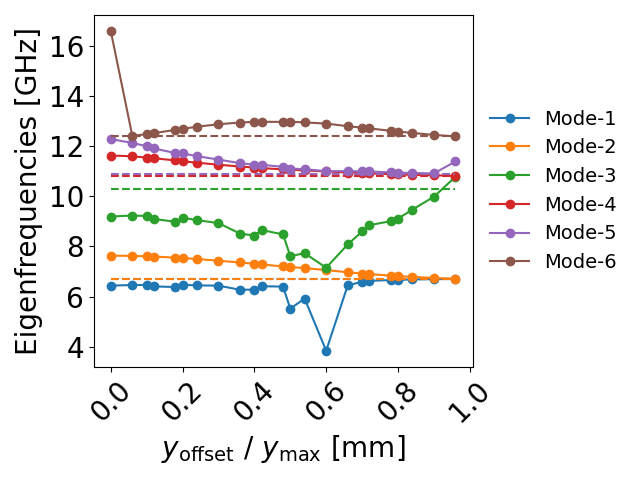

In [119]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(xdata/xscale, wppp/(2*np.pi*fscale),
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(xdata/xscale, [wp0[idx]/(2*np.pi*fscale)] * len(xdata),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$y_{\mathrm{offset}}\ /\ y_{\mathrm{max}}$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('linear')
fig.savefig(f'../figs/modes_term_bbq_inductive_yoffset_50um_{dstr}.pdf', format='pdf')

## Blackbox participation extraction

<IPython.core.display.Javascript object>


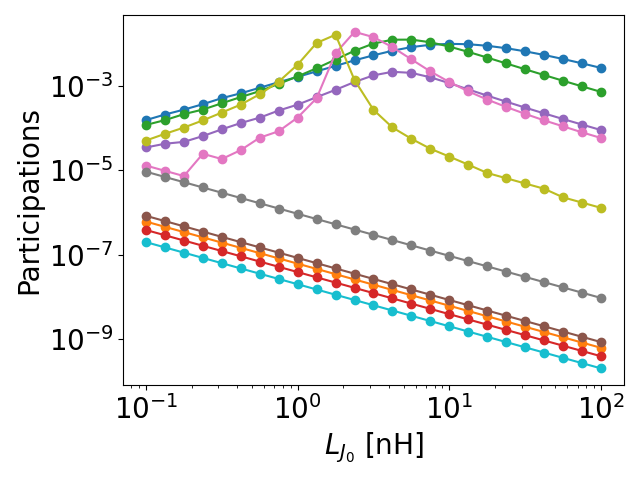

In [107]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, pp in enumerate(ps):
    ax.plot(LJs/1e-9, pp,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel('Participations', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/participations_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## $\frac{g}{\Delta}$ From Blackbox

<IPython.core.display.Javascript object>


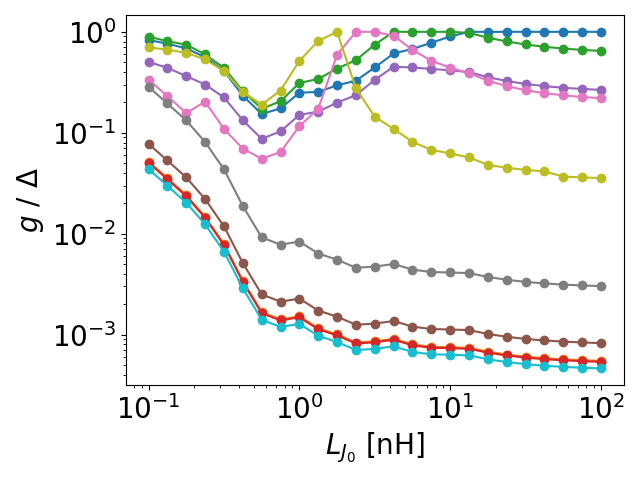

In [108]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, gg in enumerate(gDs):
    ax.plot(LJs/1e-9, gg,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$g\ /\ \Delta$', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/g_over_D_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## $\chi$ from Black box

<IPython.core.display.Javascript object>


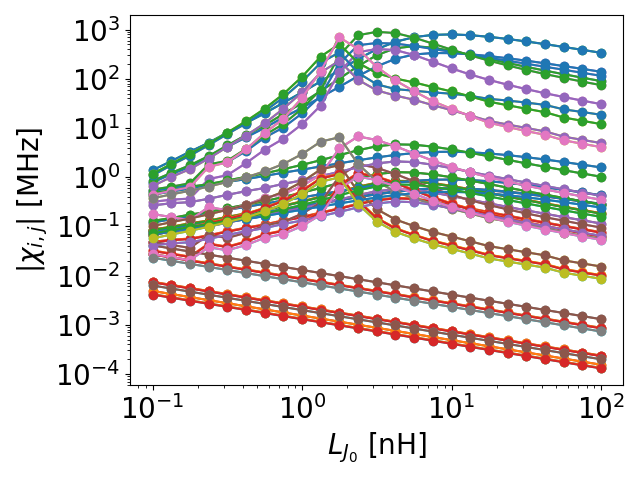

In [58]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
    for idx2 in range(M2):
        if idx1 != idx2:
            ax.plot(LJs/1e-9, np.abs(chis[idx1, idx2, :])/chi_scale,
            'o-', label=r'$|\chi_{%d, %d}|$' % (idx1, idx2),
            color=cycle[(idx1*Nmodes+idx2)%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{i, j}|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/chis_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## $\alpha$ from Black box

<IPython.core.display.Javascript object>


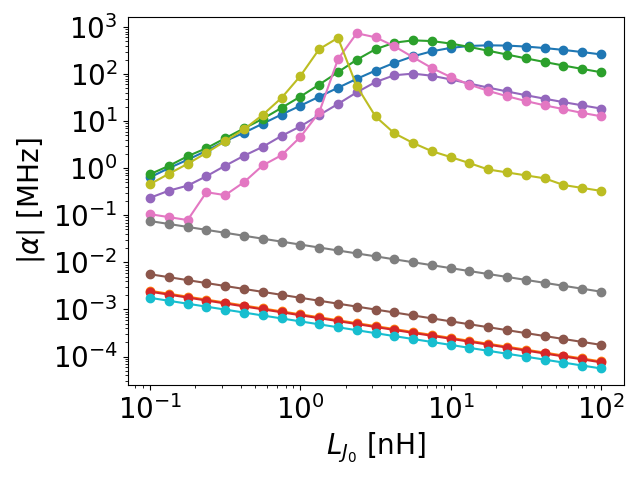

In [59]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
chi_scale = 1e6
chi_dict = {1e6: 'MHz', 1e9 : 'GHz'}
chi_str = chi_dict[chi_scale]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
M1, M2 = [Nmodes, Nmodes]
for idx1 in range(M1):
        ax.plot(LJs/1e-9, 
                0.5 * np.abs(chis[idx1, idx1, :])/chi_scale,
                'o-', label=r'$|\alpha_{%d}|$' % (idx1),
                color=cycle[idx1%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha|$ [%s]' % (chi_str),
              fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/alpha_bbq_inductive_50um_{dstr}.pdf',
           format='pdf')

## Mode Capacitances, Inductances

<IPython.core.display.Javascript object>


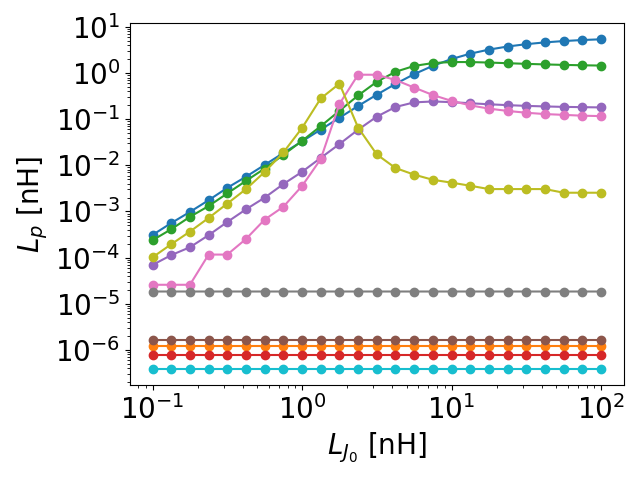

In [60]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Lppp in enumerate(Lps):
    ax.plot(LJs/1e-9, Lppp / 1e-9,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$L_p$ [nH]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Lp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

<IPython.core.display.Javascript object>


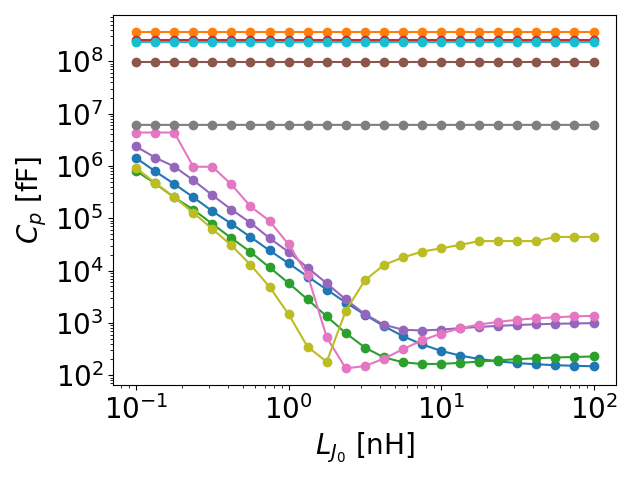

In [61]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, Cppp / 1e-15,
            'o-',color=cycle[idx%clen])
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$C_p$ [fF]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Cp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')

## Mode Impedances

<IPython.core.display.Javascript object>


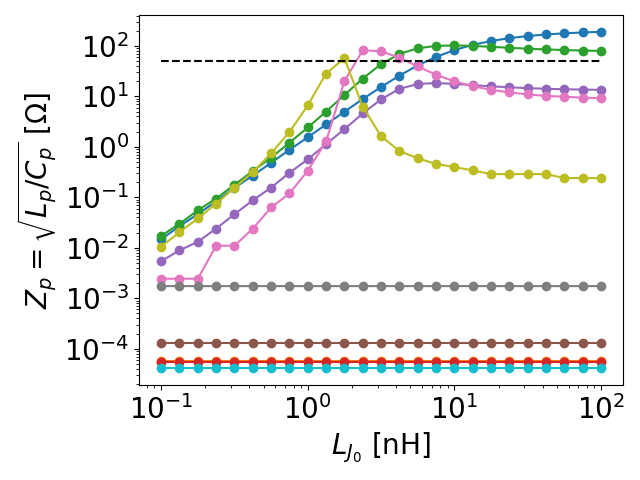

In [62]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Cppp in enumerate(Cps):
    ax.plot(LJs/1e-9, np.sqrt(Lps[idx] / Cppp),
            'o-',color=cycle[idx%clen])
ax.plot(LJs / 1e-9, [50.] * len(LJs), 'k--')
ax.set_xlabel(r'$L_{J_0}$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Z_p=\sqrt{L_p/C_p}$ [$\Omega$]', fontsize=fsize)
set_axes_fonts(ax, fsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/Zp_term_bbq_inductive_50um_{dstr}.pdf',
            format='pdf')